Using device: cpu


Training: 100%|█████████████████| 6000/6000 [00:10<00:00, 550.52it/s, loss=0.000010, kappa=0.499973]
/var/folders/w8/xz590jyd7r36zmxcspgzj3z40000gn/T/ipykernel_52669/823714267.py:227: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


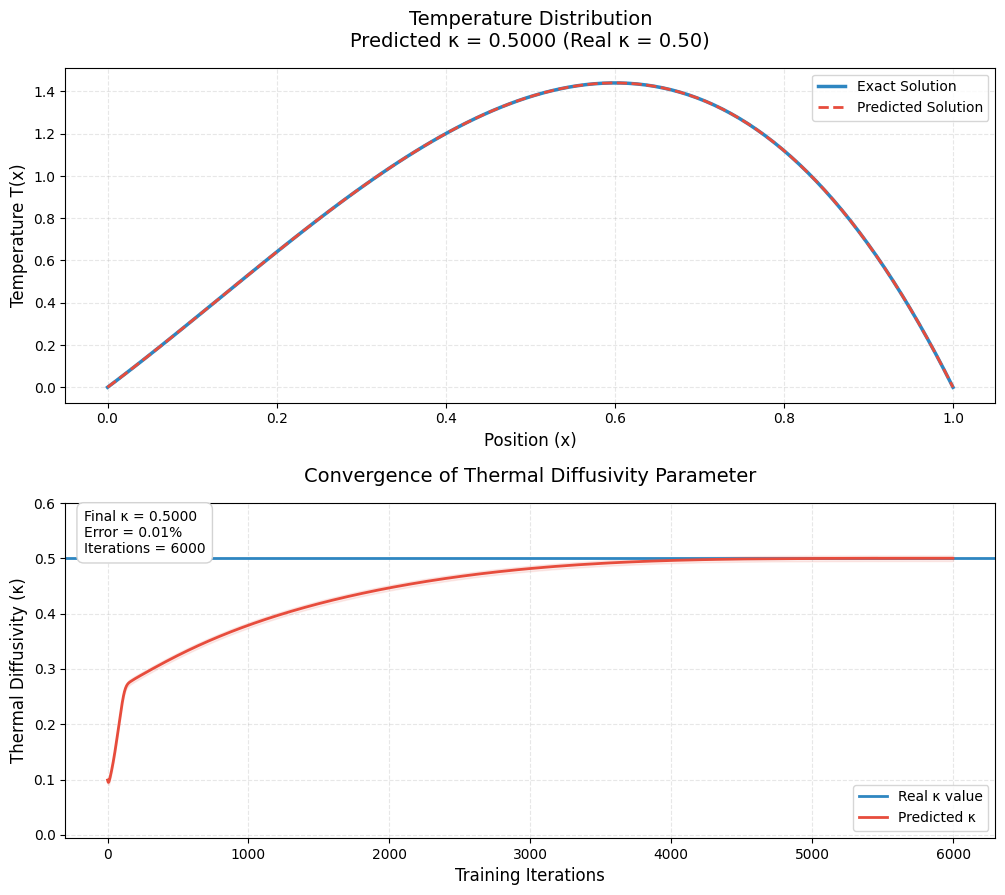

In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class PINN(nn.Module):
    def __init__(self, num_hidden_layers, num_neurons_per_layer):
        super(PINN, self).__init__()
        
        layers = []
        # Input layer
        layers.append(nn.Linear(1, num_neurons_per_layer))
        layers.append(nn.Tanh())
        
        # Hidden layers
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(num_neurons_per_layer, num_neurons_per_layer))
            layers.append(nn.Tanh())
            
        # Output layer
        layers.append(nn.Linear(num_neurons_per_layer, 1))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

class HeatTransfer:
    def __init__(self, num_points=100, hidden_layers=3, neurons_per_layer=32, learning_rate=1e-3):
        # Set seeds for reproducibility
        torch.manual_seed(123)
        np.random.seed(123)
        
        # Check for CUDA availability
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        # Domain setup
        self.x = torch.linspace(0.0, 1.0, num_points).to(self.device)
        self.x_interior = self.x[1:-1].reshape(-1, 1)
        self.x_interior.requires_grad_(True)
        
        # Boundary conditions
        self.bcs_x = torch.tensor([[0.0], [1.0]], dtype=torch.float32).to(self.device)
        self.bcs_T = torch.tensor([[0.0], [0.0]], dtype=torch.float32).to(self.device)
        
        # Model and parameter setup
        self.model = PINN(hidden_layers, neurons_per_layer).to(self.device)
        self.kappa = nn.Parameter(torch.tensor([0.1], dtype=torch.float32, device=self.device))
        
        # Optimizer
        self.optimizer = torch.optim.Adam([
            {'params': self.model.parameters()},
            {'params': [self.kappa]}
        ], lr=learning_rate)
        
        # History tracking
        self.kappa_history = []
        self.loss_history = []
    
    @staticmethod
    def exact_solution(x):
        """Exact solution of the heat equation"""
        return -5 * x**3 + 2 * x**2 + 3 * x
    
    @staticmethod
    def source_function(x):
        """Source term in the heat equation"""
        return 15 * x - 2
    
    def get_derivatives(self, x, T):
        """Calculate first and second derivatives using autograd"""
        T_x = torch.autograd.grad(
            T, x,
            grad_outputs=torch.ones_like(T, device=self.device),
            create_graph=True,
            retain_graph=True
        )[0]
        
        T_xx = torch.autograd.grad(
            T_x, x,
            grad_outputs=torch.ones_like(T_x, device=self.device),
            create_graph=True,
            retain_graph=True
        )[0]
        
        return T_x, T_xx
    
    def compute_boundary_loss(self):
        """Compute loss at boundary points"""
        predicted_bcs = self.model(self.bcs_x)
        return torch.mean((predicted_bcs - self.bcs_T)**2)
    
    def compute_physics_loss(self):
        """Compute physics-informed loss"""
        T = self.model(self.x_interior)
        _, T_xx = self.get_derivatives(self.x_interior, T)
        return torch.mean((self.kappa * T_xx + self.source_function(self.x_interior))**2)
    
    def compute_data_loss(self):
        """Compute loss against observed data"""
        observed_T = self.exact_solution(self.x_interior)
        predicted_T = self.model(self.x_interior)
        return torch.mean((observed_T - predicted_T)**2)
    
    def train(self, epochs=6000):
        """Train the model"""
        pbar = tqdm(range(epochs), desc='Training', ncols=100)
        
        for epoch in pbar:
            # Zero gradients
            self.optimizer.zero_grad()
            
            # Compute losses
            b_loss = self.compute_boundary_loss()
            p_loss = self.compute_physics_loss()
            d_loss = self.compute_data_loss()
            
            # Total loss
            total_loss = b_loss + p_loss + d_loss
            
            # Backward pass and optimization
            total_loss.backward()
            self.optimizer.step()
            
            # Record history
            self.kappa_history.append(self.kappa.item())
            self.loss_history.append(total_loss.item())
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{total_loss.item():.6f}',
                'kappa': f'{self.kappa.item():.6f}'
            })
    
    def plot_results(self):
        """Plot the results with clean white background styling"""
        # Set the style to default white background
        plt.style.use('default')
        
        # Create figure and grid
        fig = plt.figure(figsize=(12, 10))
        gs = plt.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.3)
        
        # Plot 1: Temperature Distribution
        ax1 = plt.subplot(gs[0])
        with torch.no_grad():
            x_plot = self.x.reshape(-1, 1)
            T_pred = self.model(x_plot).cpu().numpy().flatten()  # Flatten the array
        T_exact = self.exact_solution(self.x.cpu().numpy())
        x_numpy = self.x.cpu().numpy()
        
        ax1.plot(x_numpy, T_exact, 
                color='#2E86C1', linewidth=2.5, label='Exact Solution')
        ax1.plot(x_numpy, T_pred, 
                color='#E74C3C', linewidth=2, linestyle='--', label='Predicted Solution')
        
        ax1.set_xlabel('Position (x)', fontsize=12)
        ax1.set_ylabel('Temperature T(x)', fontsize=12)
        ax1.set_title('Temperature Distribution\n' + 
                    f'Predicted κ = {self.kappa.item():.4f} (Real κ = 0.50)',
                    fontsize=14, pad=15)
        ax1.legend(loc='best', fontsize=10, frameon=True)
        ax1.grid(True, linestyle='--', alpha=0.3)
        
        # Add shaded area between curves to highlight differences
        ax1.fill_between(x_numpy, T_exact, T_pred, 
                        color='#E74C3C', alpha=0.1)
        
        # Set background color
        ax1.set_facecolor('white')
        
        # Plot 2: Kappa Evolution
        ax2 = plt.subplot(gs[1])
        iterations = np.arange(len(self.kappa_history))
        
        # Plot real value
        ax2.axhline(y=0.5, color='#2E86C1', linewidth=2, 
                    label='Real κ value')
        
        # Plot predicted values
        points = np.array(self.kappa_history)
        ax2.plot(iterations, points, color='#E74C3C', 
                linewidth=2, label='Predicted κ')
        
        # Add confidence interval
        mean = np.mean(points[len(points)//2:])  # mean of latter half
        std = np.std(points[len(points)//2:])    # std of latter half
        ax2.fill_between(iterations, points - std, points + std, 
                        color='#E74C3C', alpha=0.1)
        
        ax2.set_xlabel('Training Iterations', fontsize=12)
        ax2.set_ylabel('Thermal Diffusivity (κ)', fontsize=12)
        ax2.set_title('Convergence of Thermal Diffusivity Parameter', 
                    fontsize=14, pad=15)
        ax2.legend(loc='best', fontsize=10, frameon=True)
        ax2.grid(True, linestyle='--', alpha=0.3)
        
        # Set background color
        ax2.set_facecolor('white')
        
        # Set y-axis limits with some padding
        y_min = min(points) - 0.1
        y_max = max(points) + 0.1
        ax2.set_ylim([y_min, y_max])
        
        # Add text box with final statistics
        final_kappa = self.kappa_history[-1]
        error_percentage = abs((final_kappa - 0.5) / 0.5 * 100)
        stats_text = (f'Final κ = {final_kappa:.4f}\n'
                    f'Error = {error_percentage:.2f}%\n'
                    f'Iterations = {len(self.kappa_history)}')
        
        # Add text box with white background and border
        plt.text(0.02, 0.98, stats_text,
                transform=ax2.transAxes,
                bbox=dict(facecolor='white', alpha=1.0, 
                        edgecolor='lightgray', boxstyle='round,pad=0.5'),
                verticalalignment='top',
                fontsize=10)
        
        # Set figure background color
        fig.patch.set_facecolor('white')
        
        # Adjust layout and save
        plt.tight_layout()
        
        # Save with high DPI for better quality
        # plt.savefig('inverse-heat-diffusivity.pdf', 
        #             dpi=300, bbox_inches='tight',
        #             facecolor='white', edgecolor='none')
        plt.show()
def main():
    # Create and train the model
    heat_transfer = HeatTransfer()
    heat_transfer.train()
    heat_transfer.plot_results()

if __name__ == "__main__":
    main()